In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
from pysqlcipher3 import dbapi2 as sqlite
from os import environ
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 500)
import matplotlib.patches as mpatches
from sklearn import preprocessing
from sklearn import cluster

This notebook is intended for finding clusters from the block groups based on different characteristics of trips taken by the toll users <br>
This notebook is developed by modifying the following notebooks <br>
http://darribas.org/gds15/content/labs/lab_08.html <br>
Shirely notebook for maps <br>

In [2]:
keynow = environ['HOT_KEY']
conn = sqlite.connect('/opt/dssg-hot/data/hot-v3.db')
conn.execute('pragma key=\"x\''+keynow+'\'\"')

We want to allocate percent of trips taken by each group of users (for example morning peak NB, morning peak SB,... ) at each block group <br>
We want to allocate percent of trips taken on each route (for example entry_2_exit_2, entry_13_exit_14 ) at each block group <br>
Reading the block group summary table from database <br>
Reading acs data <br>

In [3]:
dfpeak = pd.read_sql_query("SELECT fips, peak_group FROM Agg_new WHERE aux3 != 'GP_18_18' AND plate_state = 'WA' AND num_tag <= 6 AND frequency <= 10000 AND fips_code IS NOT NULL", conn)
peak_table = pd.pivot_table(dfpeak, values='peak_group', index=['fips'],columns=['peak_group'], aggfunc=len)
dfpeak = pd.DataFrame(peak_table.to_records())
dfpeak = dfpeak.fillna(0)
dfpeak['fips'] = dfpeak['fips'].astype(str).replace('\.0', '', regex=True)

In [4]:
dfroute = pd.read_sql_query("SELECT fips, route FROM Agg_new WHERE aux3 != 'GP_18_18' AND plate_state = 'WA' AND num_tag <= 6 AND frequency <= 10000 AND fips_code IS NOT NULL", conn)
route_table = pd.pivot_table(dfroute, values='route', index=['fips'],columns=['route'], aggfunc=len)
dfroute = pd.DataFrame(route_table.to_records())
dfroute = dfroute.fillna(0)
dfroute['fips'] = dfroute['fips'].astype(str).replace('\.0', '', regex=True)

In [5]:
df = pd.read_sql_query("SELECT * FROM fips_toll_w_com", conn)
df['fips'].dropna(inplace =True)
df['fips'] = df['fips'].astype(str).replace('\.0', '', regex=True)
df = df[['fips','tract', 'num_trips','num_account', 'sum_toll','sum_benefit','num_hov', 'avg_toll', 'avg_dist', 'avg_relibility','avg_ttsaving']]
acs = pd.read_csv('../../data/acs/block_group_census_estimates_wide_wsdot_bins_all_WA.csv')
acs.rename(columns = {'fips_code':'fips'},inplace = True)
acs['fips'] = acs['fips'].astype(str).replace('\.0', '', regex=True)


In [6]:
print(df['tract'])

0       950300
1       950300
2       960300
3        10100
4        10100
         ...  
3301      3200
3302      3200
3303      3400
3304      3400
3305    940002
Name: tract, Length: 3306, dtype: int64


Reading shapefiles
Shirely's notebook

In [7]:
shape = gpd.read_file('../../data/shapefiles//block_groups_WA/bg10.shp')
shape['geometry'] = shape['geometry'].to_crs(epsg=4326)
shape.rename(columns = {'GEOID10':'fips'},inplace = True)
shape['fips'] = shape['fips'].astype(str)
citypts = gpd.read_file('../../data/shapefiles/city_points/city_points.shp')
citypts['geometry'] = citypts['geometry'].to_crs(epsg=4326)
majcps = citypts[(citypts['NAME']=='Seattle')|(citypts['NAME']=='Bellevue')
                 |(citypts['NAME']=='Lynnwood')|(citypts['NAME']=='Woodinville')
                 |(citypts['NAME']=='Bothell')|(citypts['NAME']=='Shoreline')
                 |(citypts['NAME']=='Edmonds')|(citypts['NAME']=='Redmond')
                 |(citypts['NAME']=='Kirkland')|(citypts['NAME']=='Renton')
                 |(citypts['NAME']=='Kent')|(citypts['NAME']=='Issquah')
                 |(citypts['NAME']=='Everett')|(citypts['NAME']=='SeaTac')]
water = gpd.read_file('../../data/shapefiles/water/water_bodies.shp')
water['geometry'] =water['geometry'].to_crs(epsg=4326)
majlks = water[(water['NAME']=='Green Lake')|(water['NAME']=='Lake Union')
                |(water['NAME']=='Lake Meridian')|(water['NAME']=='Salmon Bay')
                |(water['NAME']=='Lake Washington')|(water['NAME']=='Lake Sammamish')
                |(water['NAME']=='Lake Youngs')|(water['NAME']=='Lake Stevens')]


Merging data files

In [8]:
dfnew = pd.merge(df,shape,on='fips')
dfnew = pd.merge(dfnew,dfpeak,on='fips')
dfnew = pd.merge(dfnew,acs,on='fips')
dfnew = pd.merge(dfnew,dfroute,on='fips')
dfnew.reset_index(drop = True,inplace = True)

Normalizing route and peak groups

In [9]:
routeind = dfroute.columns.to_list()
routeind.remove('fips')
routes_to_normalize = ['norm_'+ str(i) for i in routeind]
dfnew[routes_to_normalize] = dfnew[routeind].div(dfnew['num_trips'],axis=0)
peakind =  dfpeak.columns.to_list()
peakind.remove('fips')
peak_to_normalize = ['norm_'+ str(i) for i in peakind]
dfnew[peak_to_normalize] = dfnew[peakind].div(dfnew['num_trips'],axis=0)

Adding more features

In [10]:
dfnew = gpd.GeoDataFrame(dfnew, geometry='geometry')
# Shirely
dfnew['lon'] = dfnew.centroid.x
dfnew['lat'] = dfnew.centroid.y
dfnew['percent_hov'] = dfnew['num_hov']/dfnew['num_trips']
dfnew['total_tt_saving'] =  dfnew['avg_ttsaving'] * dfnew['num_trips']
dfnew['total_reliability_saving'] =  dfnew['avg_relibility'] * dfnew['num_trips']
dfnew['trips_per_hh'] = dfnew['num_trips']/ dfnew['households'] 
print(dfnew['lon'].head(5))

0   -119.181625
1   -119.203012
2   -117.055824
3   -119.267181
4   -119.262555
Name: lon, dtype: float64


Making some plots of the block groups features <br>
From the notebook cited

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:385: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:389: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
/opt/conda/lib/python3.7/site-packages/mapclassify/classifiers.py:276: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/opt/conda/lib/python3.7/site-packages/mapclassify/classifiers.py:276: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


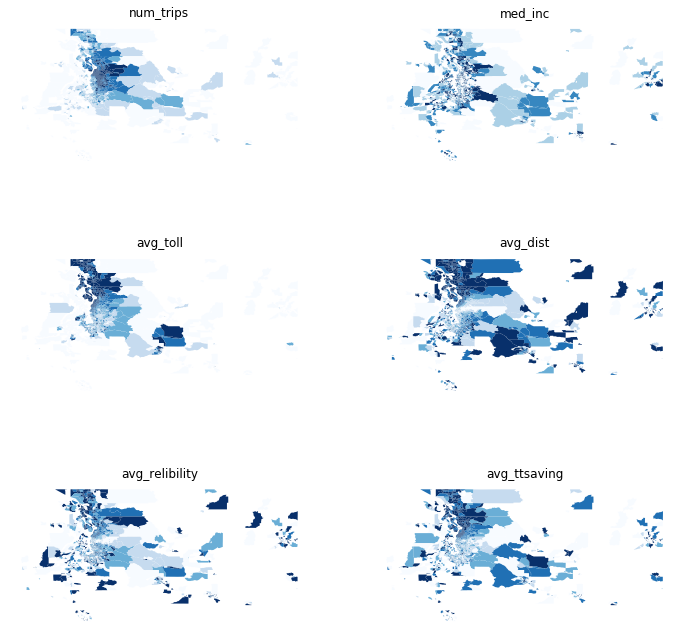

In [63]:
features = ['num_trips','med_inc', 'avg_toll', 'avg_dist', 'avg_relibility', 'avg_ttsaving']
figure, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axs = axs.flatten()
for i, col in enumerate(features):
    ax = axs[i]
    dfnew.plot(column = col, axes=ax,scheme='QUANTILES' , linewidth=0, colormap='Blues')
    ax.set_axis_off()
    ax.set_title(col)
plt.show()
figure.savefig('../../notebooks/Kiana/figures/exploring_plot_fips_w_c',dpi = 400)

Making plots that show the relationship between variables <br>
From the notebook cited

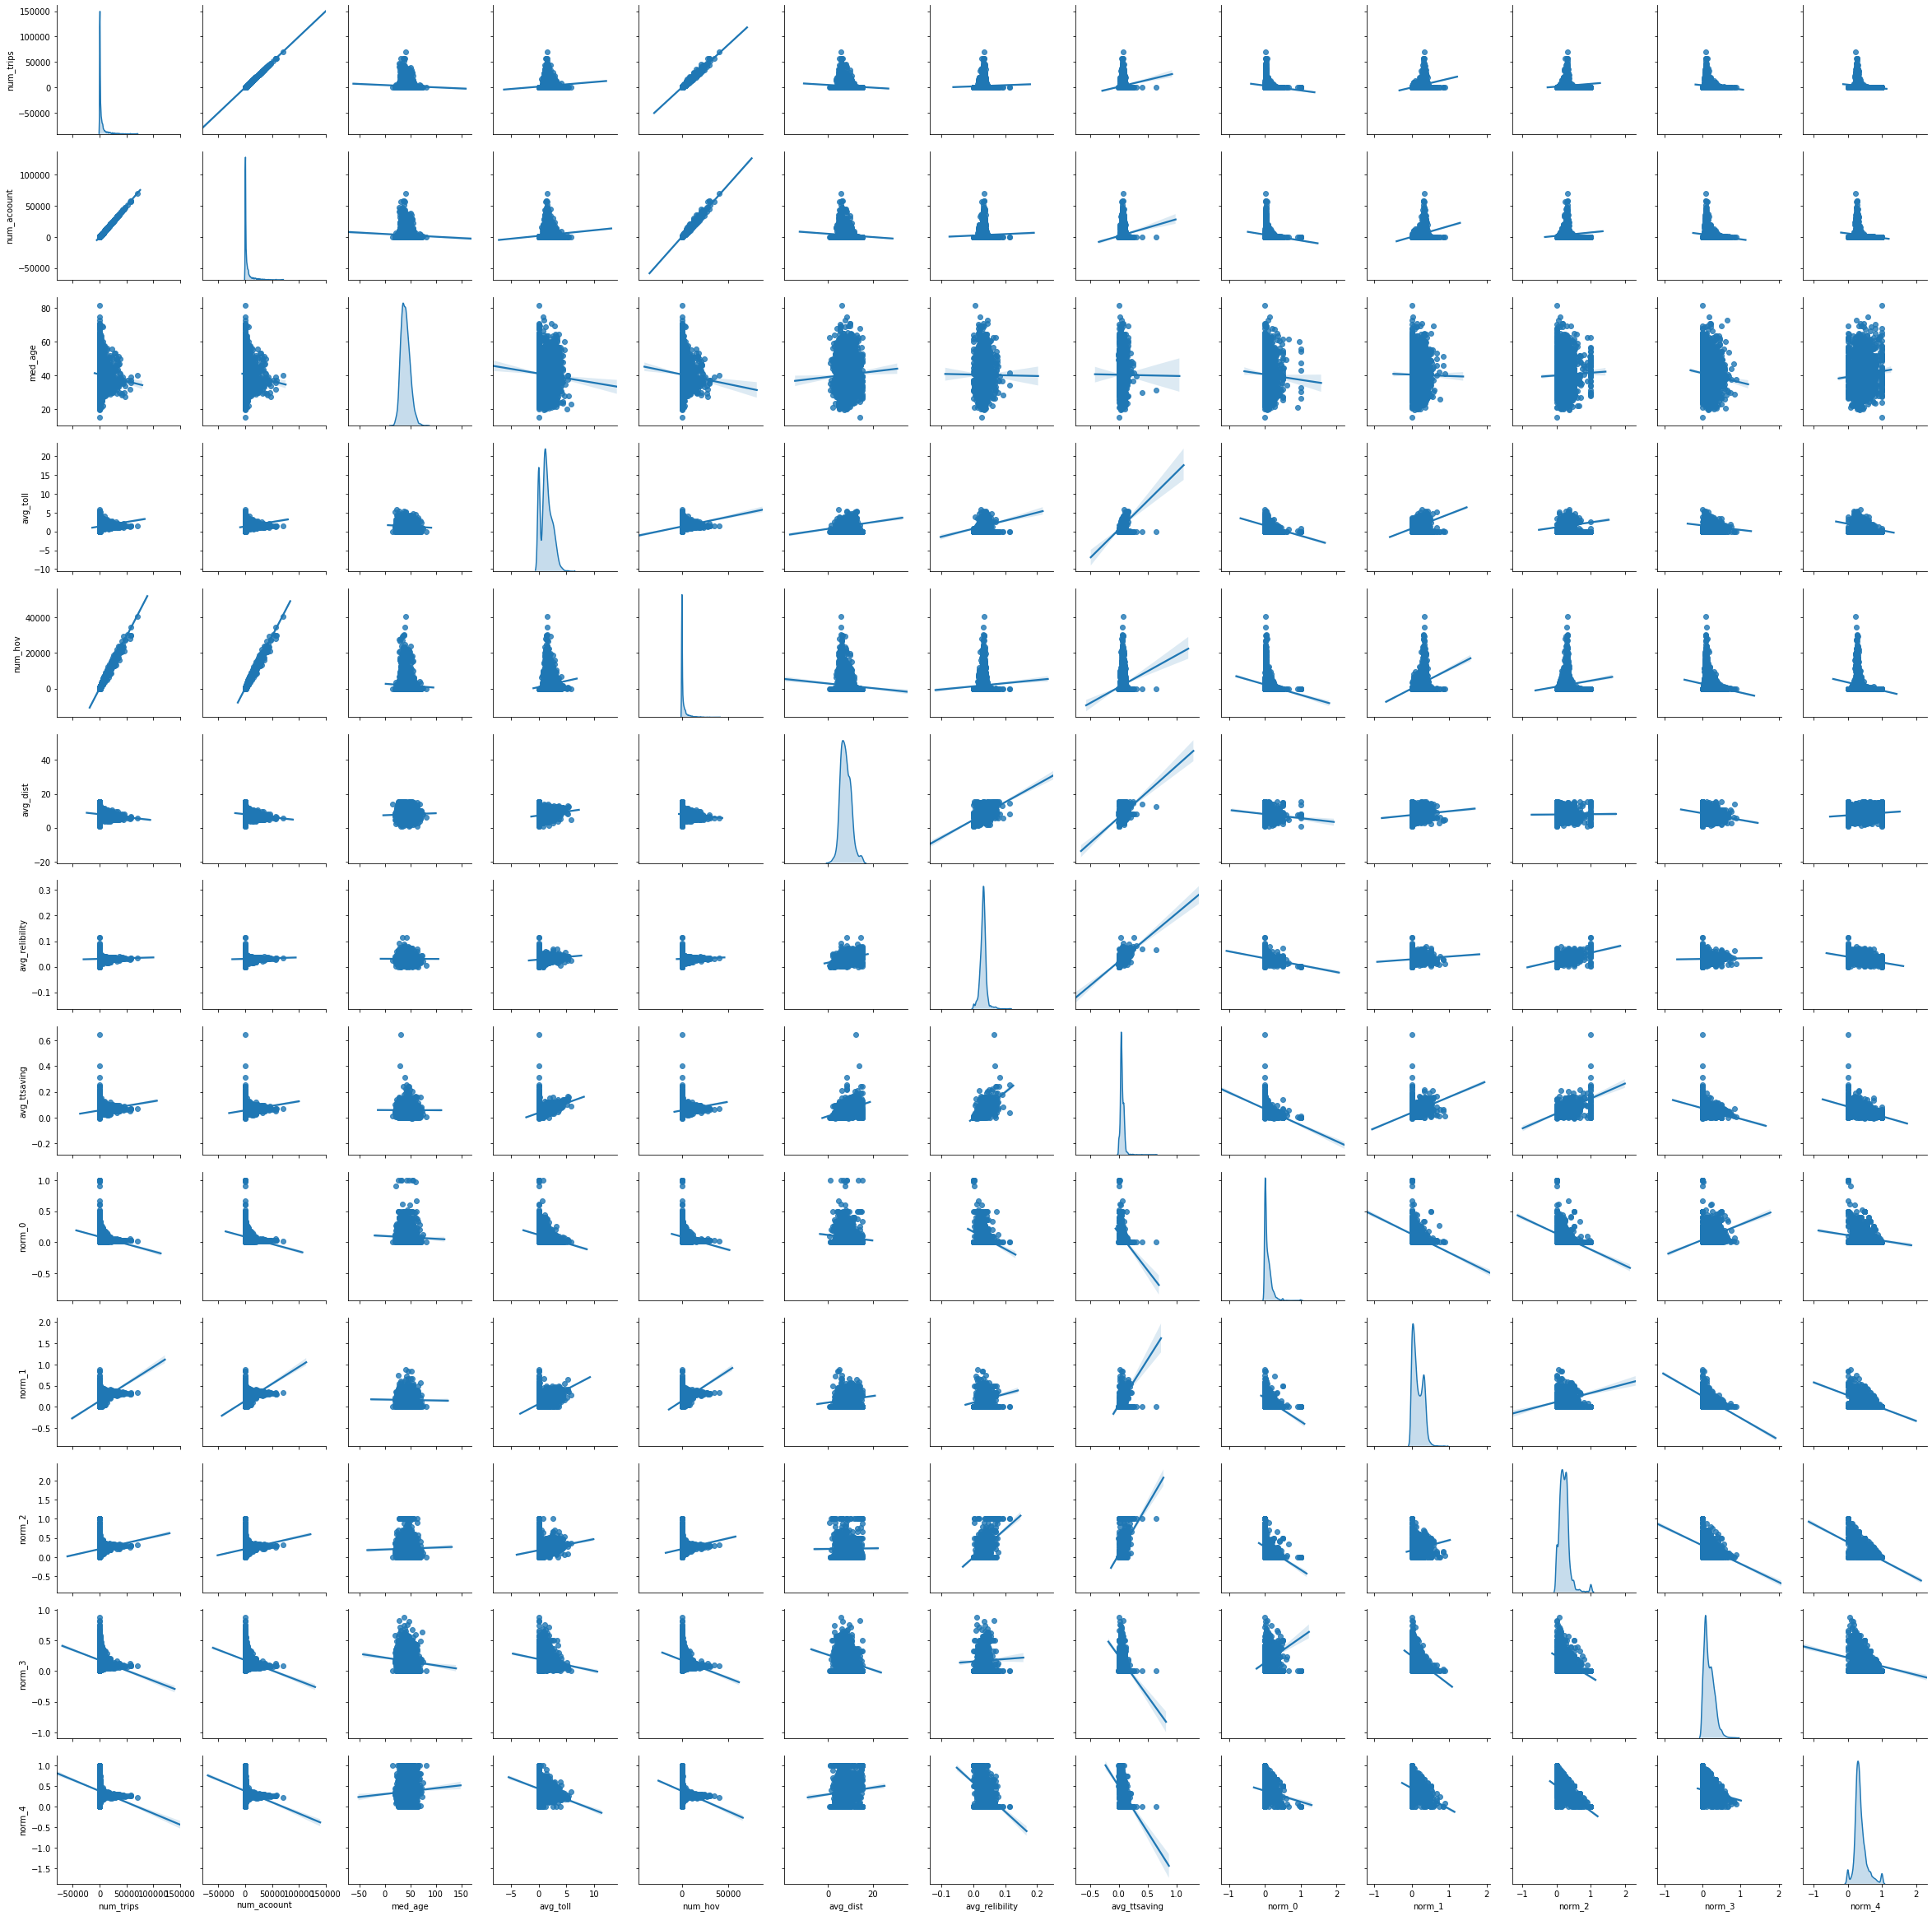

In [16]:
features = ['num_trips','num_account','med_age', 'avg_toll', 'num_hov','avg_dist', 'avg_relibility', 'avg_ttsaving'] + peak_to_normalize
_ = sns.pairplot(dfnew[features], kind='reg',diag_kind='kde')
plt.savefig('../../notebooks/Kiana/figures/correlation_plot_fips_w_c',dpi = 400)

Doing clustering on block groups that have higher than treshold number of trips based on the peak groups <br>
from the cited notebook

In [11]:
from sklearn import cluster
from IPython.display import display
kmeans3 = cluster.KMeans(n_clusters=3)
dfnew  = dfnew[dfnew['trips_per_hh']>= 0.5] 
dfnew.reset_index(drop = True,inplace = True)
k3cls = kmeans3.fit(dfnew[peak_to_normalize])
k3cls.labels_
dfnew['k3cls'] = k3cls.labels_
k3sizes = dfnew.groupby('k3cls').size()
print(k3sizes)
k3means = dfnew.groupby('k3cls')[peak_to_normalize].mean()
display(k3means.T)
k3desc = dfnew.groupby('k3cls')[['trips_per_hh','avg_relibility', 'avg_ttsaving','avg_ttsaving']].describe()
display(k3desc)

k3cls
0    528
1    981
2    571
dtype: int64


k3cls,0,1,2
norm_0,0.161968,0.026151,0.093448
norm_1,0.068502,0.308732,0.124354
norm_2,0.128394,0.297413,0.183427
norm_3,0.342594,0.084010,0.189938
norm_4,0.298542,0.283693,0.408833


trips_per_hh                                                      \
             count       mean        std       min       25%       50%   
k3cls                                                                    
0            528.0   3.152226   2.996706  0.500000  1.006413  1.797936   
1            981.0  13.198632  16.869799  0.502625  1.584158  6.580479   
2            571.0   3.394316   5.628901  0.500678  0.800725  1.404762   

                             avg_relibility                                \
             75%         max          count      mean       std       min   
k3cls                                                                       
0       4.537381   15.808989          528.0  0.031992  0.006298  0.011319   
1      17.263830  107.940217          981.0  0.033159  0.005228  0.014391   
2       3.922048   75.560748          571.0  0.027811  0.005767  0.002850   

                                              avg_ttsaving            \
            25%       50%       75%       max        count      mean   
k3cls                                                                  
0      0.028865  0.032440  0.035569  0.055253        528.0  0.044443   
1      0.030085  0.033142  0.036068  0.070187        981.0  0.081031   
2      0.024067  0.027811  0.031472  0.047980        571.0  0.048994   

                                                                          \
            std       min       25%       50%       75%       max  count   
k3cls                                                                      
0      0.009281  0.019948  0.038309  0.044211  0.049366  0.105039  528.0   
1      0.020343  0.022247  0.065711  0.082720  0.094862  0.189298  981.0   
2      0.014071  0.004295  0.039759  0.046669  0.056133  0.096024  571.0   

                                                                             
           mean       std       min       25%       50%       75%       max  
k3cls                                                                        
0      0.044443  0.009281  0.019948  0.038309  0.044211  0.049366  0.105039  
1      0.081031  0.020343  0.022247  0.065711  0.082720  0.094862  0.189298  
2      0.048994  0.014071  0.004295  0.039759  0.046669  0.056133  0.096024

In [124]:
print(dfnew.columns.to_list())

['fips', 'tract_x', 'num_trips', 'num_account', 'sum_toll', 'sum_benefit', 'num_hov', 'avg_toll', 'avg_dist', 'avg_relibility', 'avg_ttsaving', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'INTPTLON10', 'INTPTLAT10', 'ALANDM', 'AWATERM', 'ALANDMI', 'AWATERMI', 'POP10', 'HHP10', 'GQ10', 'HU10', 'OHU10', 'POPWHITE', 'POPBLACK', 'POPAIAN', 'POPASIAN', 'POPNHOPI', 'POPOTH', 'POPTWO', 'POPHISP', 'POPWHITE2', 'POPBLACK2', 'POPAIAN2', 'POPASIAN2', 'POPNHOPI2', 'POPOTH2', 'POPTWO2', 'geometry', '0', '1', '2', '3', '4', 'county_name', 'county', 'tract_y', 'block_group', 'households', 'inc_000_020k', 'inc_020_035k', 'inc_035_050k', 'inc_050_075k', 'inc_075_100k', 'inc_100_125k', 'inc_125_150k', 'inc_150_200k', 'inc_200_infk', 'mean_inc', 'med_age', 'med_inc', 'pc_income', 'population', 'race_nonhisp_asian', 'race_nonhisp_white', 'trans_carpool', 'trans_drivealone', 'trans_transit', '03_03', '03_05', '03_06', '03_07', '03_09', '03_10', '03_11', '03_

suits index

In [44]:
dfnew1 = dfnew[dfnew['sum_toll']> 0]
dfnew1['fareshare'] = dfnew1['sum_toll']/dfnew1['num_account']
dfnew1['log_scaled_mean_income_hh'] = np.log(dfnew['mean_inc'])
dfnew1['log_fareshare'] = np.log(dfnew1['fareshare'])
dfnew1['tract_name'] = 'tract' + dfnew1['tract_x'].astype(str)
dfnew1['cluster'] = 'cluster' + dfnew1['k3cls'].astype(str)
print(dfnew1['log_fareshare'])
print(dfnew1['log_scaled_mean_income_hh'])
dfnew1[['cluster','log_scaled_mean_income_hh','log_fareshare']].to_csv('check.csv')

0       3.284195
1       3.609878
2       3.236049
3       2.811221
4       2.907726
          ...   
2048    2.797697
2049    2.704932
2050    2.397053
2051    2.767414
2052    3.643892
Name: log_fareshare, Length: 2051, dtype: float64
0       11.179865
1       10.924071
2       11.129777
3       11.239536
4       11.342430
          ...    
2048    11.519363
2049    11.494901
2050    11.068899
2051    11.139567
2052    12.410275
Name: log_scaled_mean_income_hh, Length: 2051, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


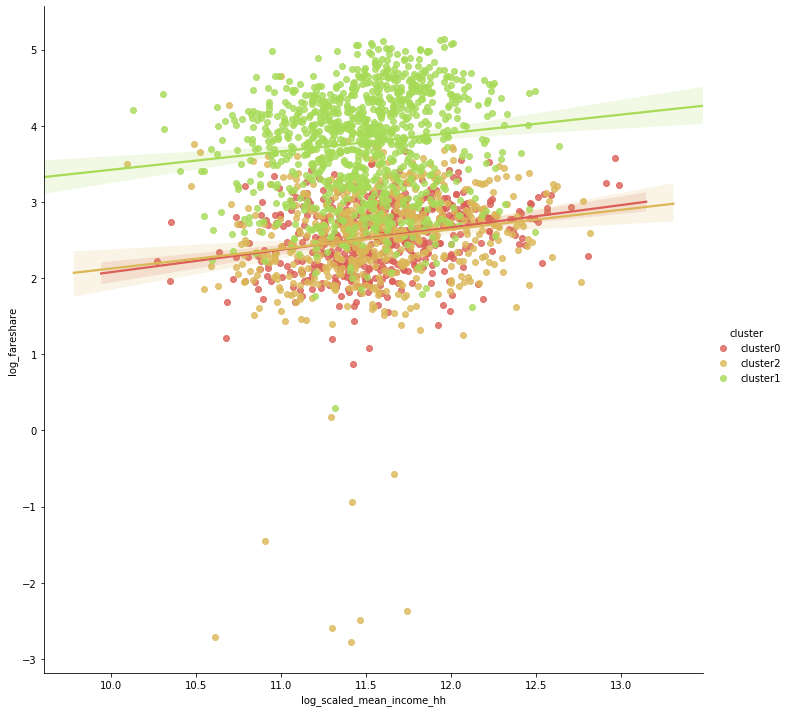

In [45]:
sns.set_palette(sns.color_palette("hls", 9))
dfnew1.sort_values(by = ['log_scaled_mean_income_hh'],ascending = False, inplace = True)
# fig, ax = plt.subplots(figsize=(30, 10))
sns.lmplot(x = 'log_scaled_mean_income_hh',y='log_fareshare',hue='cluster',data= dfnew1, height = 10)
plt.show()

In [48]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
model = smf.mixedlm("log_fareshare ~ log_scaled_mean_income_hh*cluster ", dfnew1, groups= "tract_name")
model_fit = model.fit()
print(model_fit.summary())

                         Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          log_fareshare
No. Observations:            2051             Method:                      REML         
No. Groups:                  686              Scale:                       0.1918       
Min. group size:             1                Likelihood:                  -1800.2565   
Max. group size:             9                Converged:                   Yes          
Mean group size:             3.0                                                        
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      1.675    0.745  2.250 0.024  0.216  3.135
cluster[T.cluster1]                            

In [65]:
print(dfnew.columns.to_list())
print(dfnew['k3cls'].head(5))

['index', 'fips', 'num_trips', 'num_acoount', 'num_hov', 'avg_toll', 'avg_dist', 'avg_relibility', 'avg_ttsaving', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'INTPTLON10', 'INTPTLAT10', 'ALANDM', 'AWATERM', 'ALANDMI', 'AWATERMI', 'POP10', 'HHP10', 'GQ10', 'HU10', 'OHU10', 'POPWHITE', 'POPBLACK', 'POPAIAN', 'POPASIAN', 'POPNHOPI', 'POPOTH', 'POPTWO', 'POPHISP', 'POPWHITE2', 'POPBLACK2', 'POPAIAN2', 'POPASIAN2', 'POPNHOPI2', 'POPOTH2', 'POPTWO2', 'geometry', '0', '1', '2', '3', '4', 'county_name', 'county', 'tract', 'block_group', 'households', 'inc_000_020k', 'inc_020_035k', 'inc_035_050k', 'inc_050_075k', 'inc_075_100k', 'inc_100_125k', 'inc_125_150k', 'inc_150_200k', 'inc_200_infk', 'mean_inc', 'med_age', 'med_inc', 'pc_income', 'population', 'race_nonhisp_asian', 'race_nonhisp_white', 'trans_carpool', 'trans_drivealone', 'trans_transit', '03_03', '03_05', '03_06', '03_07', '03_09', '03_10', '03_11', '03_12', '04_04', '04_05', '04_06',

In [66]:
dfnew['k3cls'].unique()

array([1, 2, 0])

1
route_cluster
0    309
1    487
2    178
dtype: int64
route_cluster         0         1         2
norm_03_03     0.015181  0.004736  0.006790
norm_03_05     0.038407  0.009030  0.032884
norm_03_06     0.025714  0.017208  0.105806
norm_03_07     0.019520  0.002850  0.005409
norm_03_09     0.014407  0.010465  0.010649
...                 ...       ...       ...
norm_21_21     0.002084  0.000864  0.001077
norm_21_22     0.026696  0.006346  0.010181
norm_21_23     0.005393  0.001327  0.002322
norm_22_22     0.008247  0.002834  0.003809
norm_23_23     0.000980  0.000459  0.000566

[99 rows x 3 columns]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


trips_per_hh                                            \
                     count       mean        std       min       25%   
route_cluster                                                          
0                    309.0  17.553305  22.647462  0.502625  1.064748   
1                    487.0   7.906698   7.106341  0.502695  2.326057   
2                    178.0  20.558023  19.360122  0.676000  6.251797   

                                                avg_relibility            \
                     50%        75%         max          count      mean   
route_cluster                                                              
0               3.125257  33.081597  107.940217          309.0  0.030427   
1               5.890625  11.179672   40.003995          487.0  0.035175   
2              14.075655  27.584061   92.989154          178.0  0.032554   

                                                                           \
                    std       min       25%       50%       75%       max   
route_cluster                                                               
0              0.005142  0.014391  0.027094  0.030530  0.033873  0.046125   
1              0.004897  0.017906  0.032424  0.034891  0.037449  0.070187   
2              0.003728  0.023425  0.030022  0.032571  0.034530  0.047166   

              avg_ttsaving                                                    \
                     count      mean       std       min       25%       50%   
route_cluster                                                                  
0                    309.0  0.066513  0.017661  0.022247  0.055383  0.063593   
1                    487.0  0.094123  0.015321  0.024725  0.085432  0.093506   
2                    178.0  0.071278  0.011850  0.036485  0.062834  0.069970   

                                                                        \
                    75%       max  count      mean       std       min   
route_cluster                                                            
0              0.079367  0.132857  309.0  0.066513  0.017661  0.022247   
1              0.102470  0.189298  487.0  0.094123  0.015321  0.024725   
2              0.078179  0.112678  178.0  0.071278  0.011850  0.036485   

                                                       
                    25%       50%       75%       max  
route_cluster                                          
0              0.055383  0.063593  0.079367  0.132857  
1              0.085432  0.093506  0.102470  0.189298  
2              0.062834  0.069970  0.078179  0.112678

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:389: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


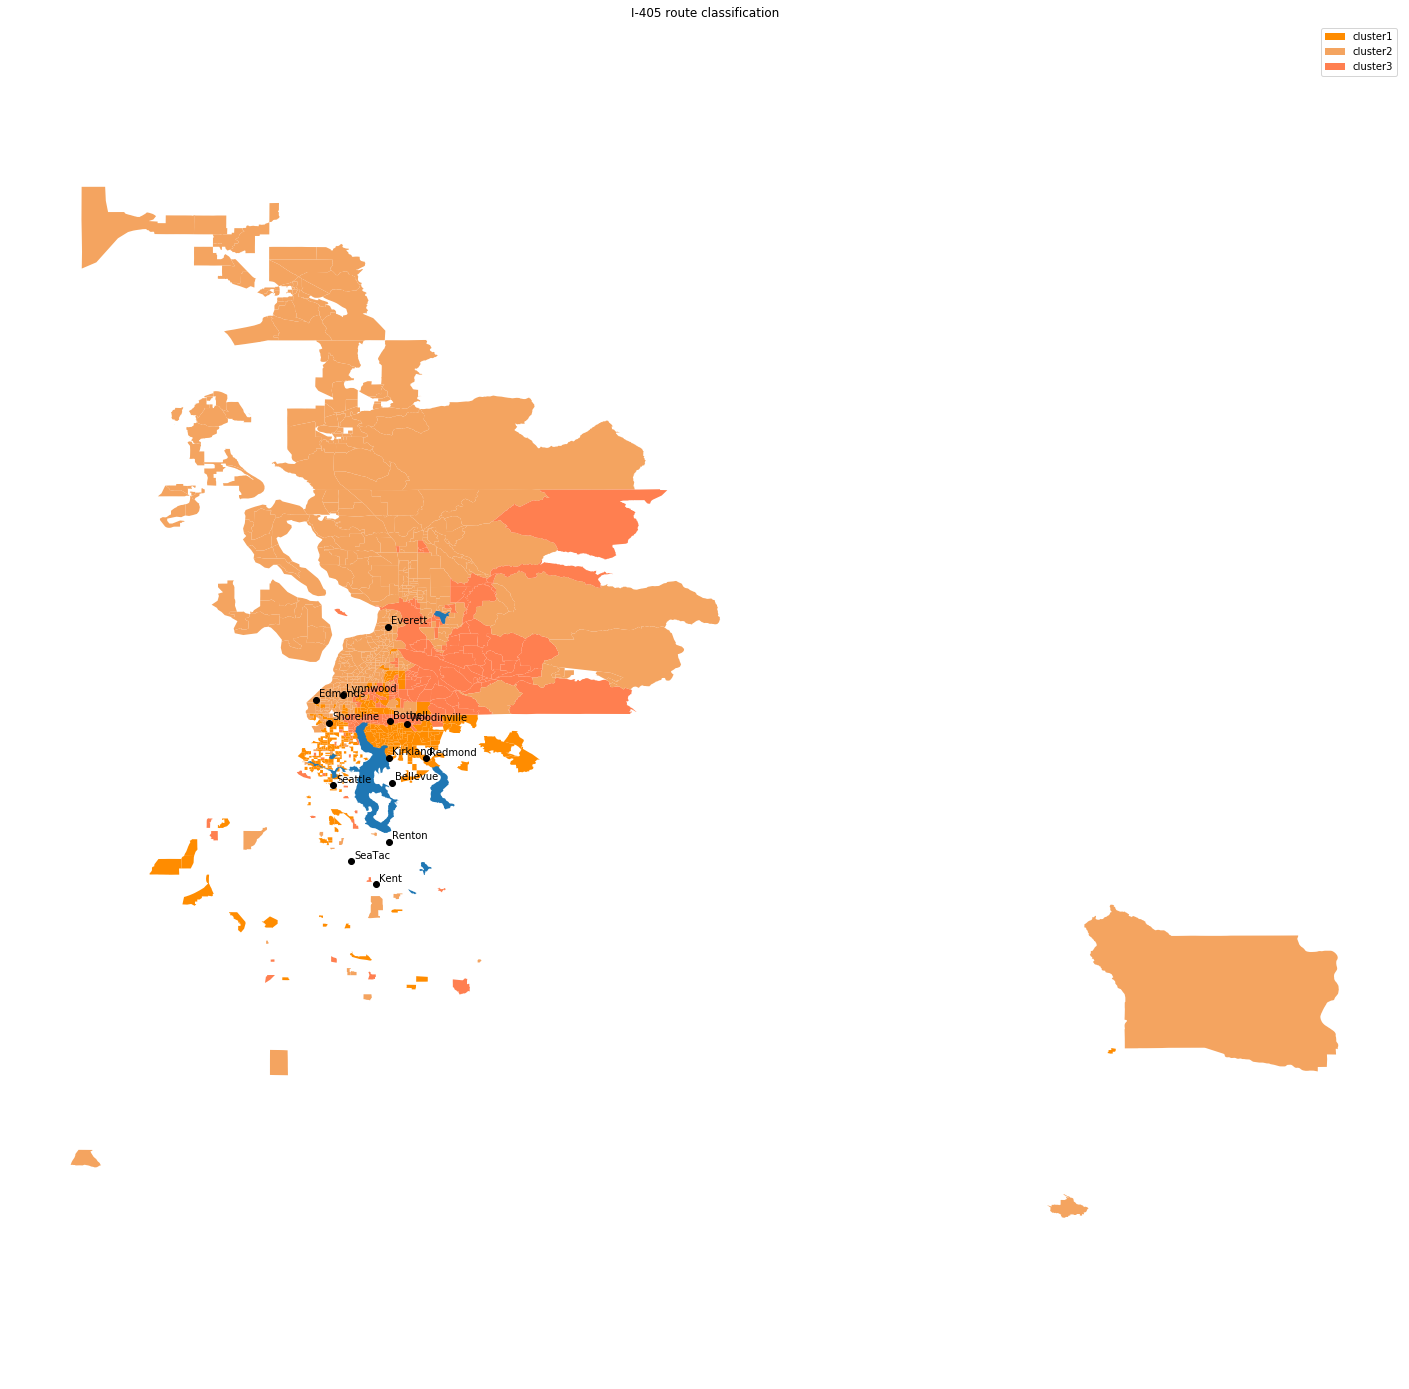

2
route_cluster
0    232
1    116
2    220
dtype: int64
route_cluster         0         1         2
norm_03_03     0.049291  0.025556  0.019237
norm_03_05     0.075353  0.031965  0.024806
norm_03_06     0.076020  0.049489  0.019557
norm_03_07     0.028130  0.010637  0.008904
norm_03_09     0.022935  0.019504  0.006331
...                 ...       ...       ...
norm_21_21     0.004747  0.002809  0.003167
norm_21_22     0.062679  0.031531  0.038552
norm_21_23     0.004929  0.002701  0.008432
norm_22_22     0.030778  0.020794  0.014839
norm_23_23     0.001973  0.001075  0.002233

[99 rows x 3 columns]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


trips_per_hh                                                    \
                     count      mean       std       min       25%       50%   
route_cluster                                                                  
0                    232.0  2.661105  6.060140  0.500678  0.789930  1.267816   
1                    116.0  1.553144  1.251960  0.504373  0.710551  1.097302   
2                    220.0  5.157108  6.113774  0.510841  0.989813  2.731263   

                                   avg_relibility                      \
                    75%        max          count      mean       std   
route_cluster                                                           
0              2.357816  75.560748          232.0  0.028489  0.004504   
1              1.708285   7.275689          116.0  0.032885  0.005157   
2              6.885872  35.567901          220.0  0.024458  0.005004   

                                                                avg_ttsaving  \
                    min       25%       50%       75%       max        count   
route_cluster                                                                  
0              0.015364  0.025580  0.028346  0.031461  0.042756        232.0   
1              0.019307  0.029174  0.032401  0.036100  0.047980        116.0   
2              0.002850  0.021391  0.024293  0.027568  0.046553        220.0   

                                                                           \
                   mean       std       min       25%       50%       75%   
route_cluster                                                               
0              0.047639  0.011348  0.022032  0.039698  0.045919  0.054801   
1              0.058715  0.018611  0.022932  0.043187  0.053532  0.074766   
2              0.045859  0.011809  0.004295  0.038647  0.045211  0.053841   

                                                                        \
                    max  count      mean       std       min       25%   
route_cluster                                                            
0              0.088441  232.0  0.047639  0.011348  0.022032  0.039698   
1              0.096024  116.0  0.058715  0.018611  0.022932  0.043187   
2              0.080629  220.0  0.045859  0.011809  0.004295  0.038647   

                                             
                    50%       75%       max  
route_cluster                                
0              0.045919  0.054801  0.088441  
1              0.053532  0.074766  0.096024  
2              0.045211  0.053841  0.080629

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:389: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


<Figure size 432x288 with 0 Axes>

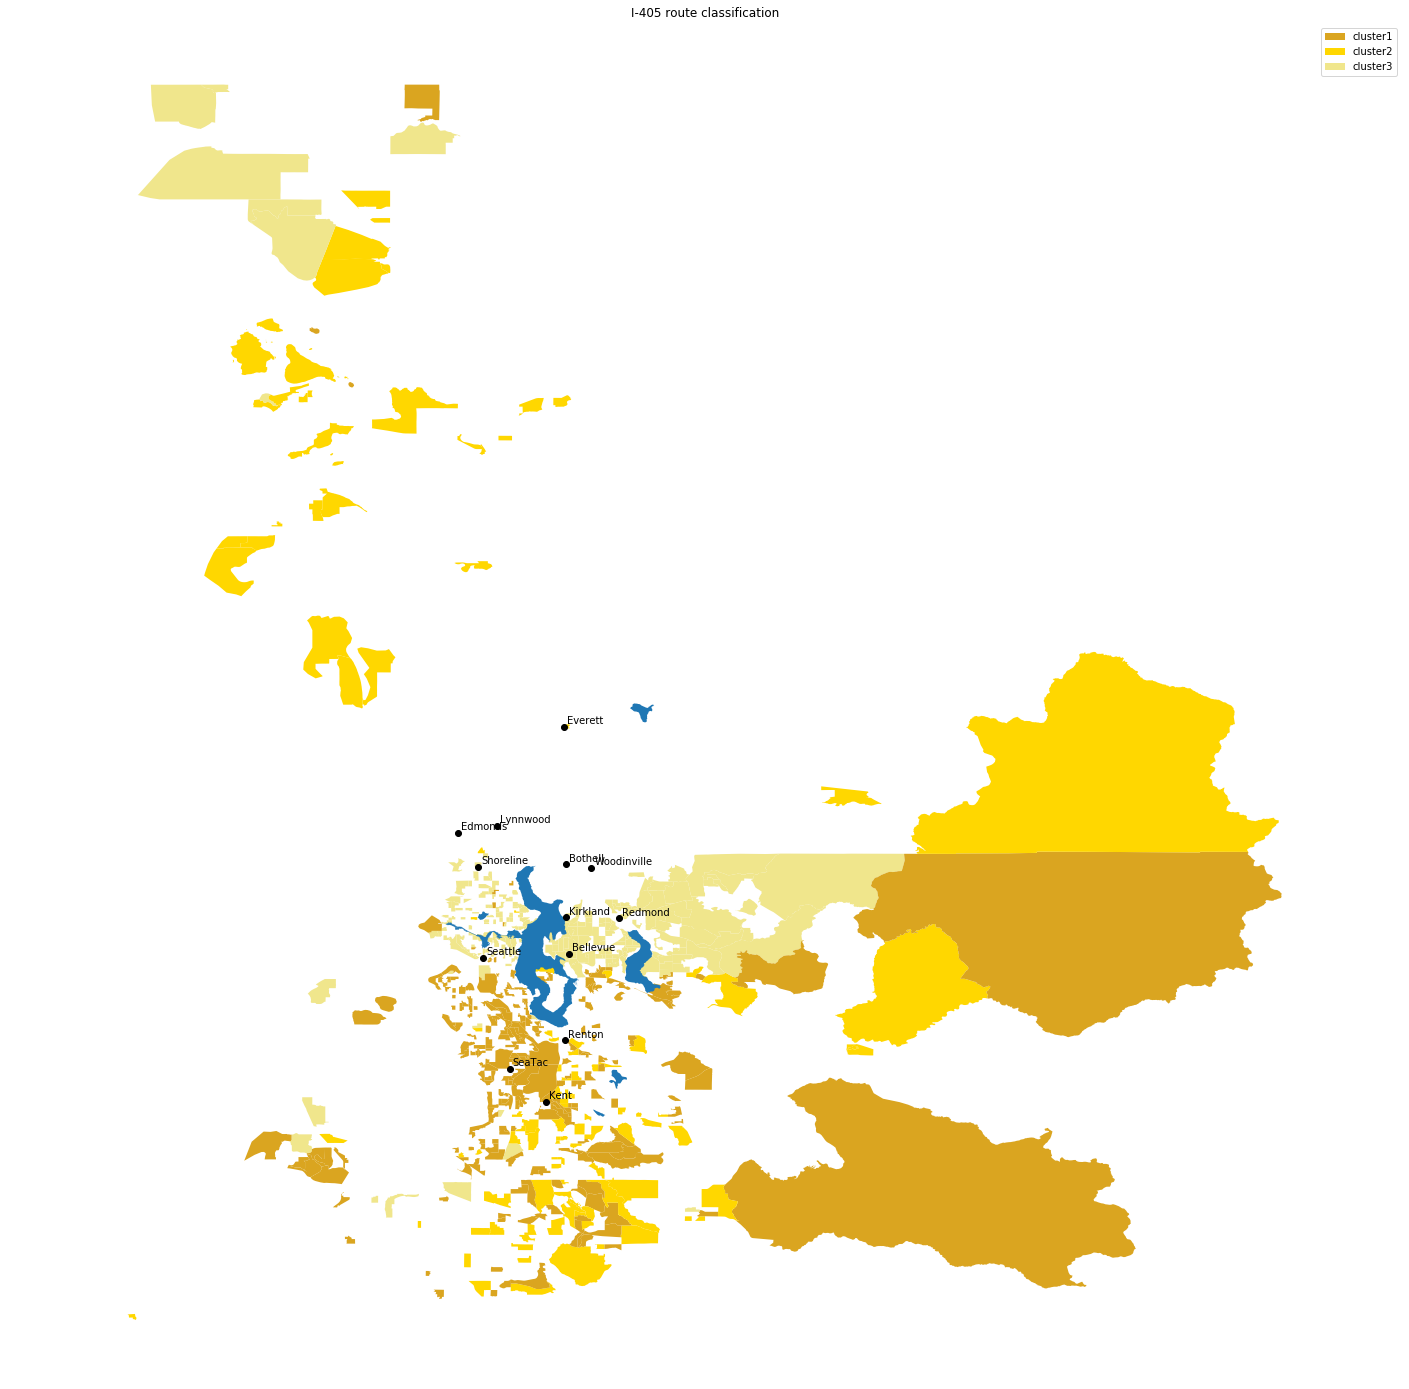

0
route_cluster
0    242
1     83
2    213
dtype: int64
route_cluster         0         1         2
norm_03_03     0.050537  0.018914  0.044038
norm_03_05     0.075619  0.023776  0.056754
norm_03_06     0.082849  0.025795  0.057882
norm_03_07     0.023670  0.010524  0.026615
norm_03_09     0.022756  0.009612  0.023548
...                 ...       ...       ...
norm_21_21     0.005383  0.002897  0.003445
norm_21_22     0.088125  0.027155  0.053453
norm_21_23     0.007191  0.010514  0.007825
norm_22_22     0.030743  0.016974  0.021113
norm_23_23     0.001751  0.001743  0.002032

[99 rows x 3 columns]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


trips_per_hh                                                    \
                     count      mean       std       min       25%       50%   
route_cluster                                                                  
0                    242.0  2.048654  2.195810  0.500000  0.861230  1.310604   
1                     83.0  2.903325  3.091825  0.506024  0.931525  1.451163   
2                    213.0  4.449162  3.196596  0.505747  1.664879  3.714981   

                                   avg_relibility                      \
                    75%        max          count      mean       std   
route_cluster                                                           
0              2.221798  13.831354          242.0  0.032656  0.005580   
1              4.735859  13.098214           83.0  0.023684  0.005825   
2              6.251948  15.808989          213.0  0.034273  0.004387   

                                                                avg_ttsaving  \
                    min       25%       50%       75%       max        count   
route_cluster                                                                  
0              0.019182  0.029329  0.032166  0.035945  0.055253        242.0   
1              0.011319  0.019631  0.023320  0.027584  0.038189         83.0   
2              0.024649  0.031566  0.033892  0.036414  0.050564        213.0   

                                                                           \
                   mean       std       min       25%       50%       75%   
route_cluster                                                               
0              0.044329  0.009201  0.024297  0.037921  0.044221  0.049407   
1              0.040990  0.011176  0.019948  0.033332  0.039216  0.048234   
2              0.045884  0.008297  0.021273  0.041006  0.045088  0.050042   

                                                                        \
                    max  count      mean       std       min       25%   
route_cluster                                                            
0              0.076524  242.0  0.044329  0.009201  0.024297  0.037921   
1              0.080667   83.0  0.040990  0.011176  0.019948  0.033332   
2              0.105039  213.0  0.045884  0.008297  0.021273  0.041006   

                                             
                    50%       75%       max  
route_cluster                                
0              0.044221  0.049407  0.076524  
1              0.039216  0.048234  0.080667  
2              0.045088  0.050042  0.105039

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:389: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


<Figure size 432x288 with 0 Axes>

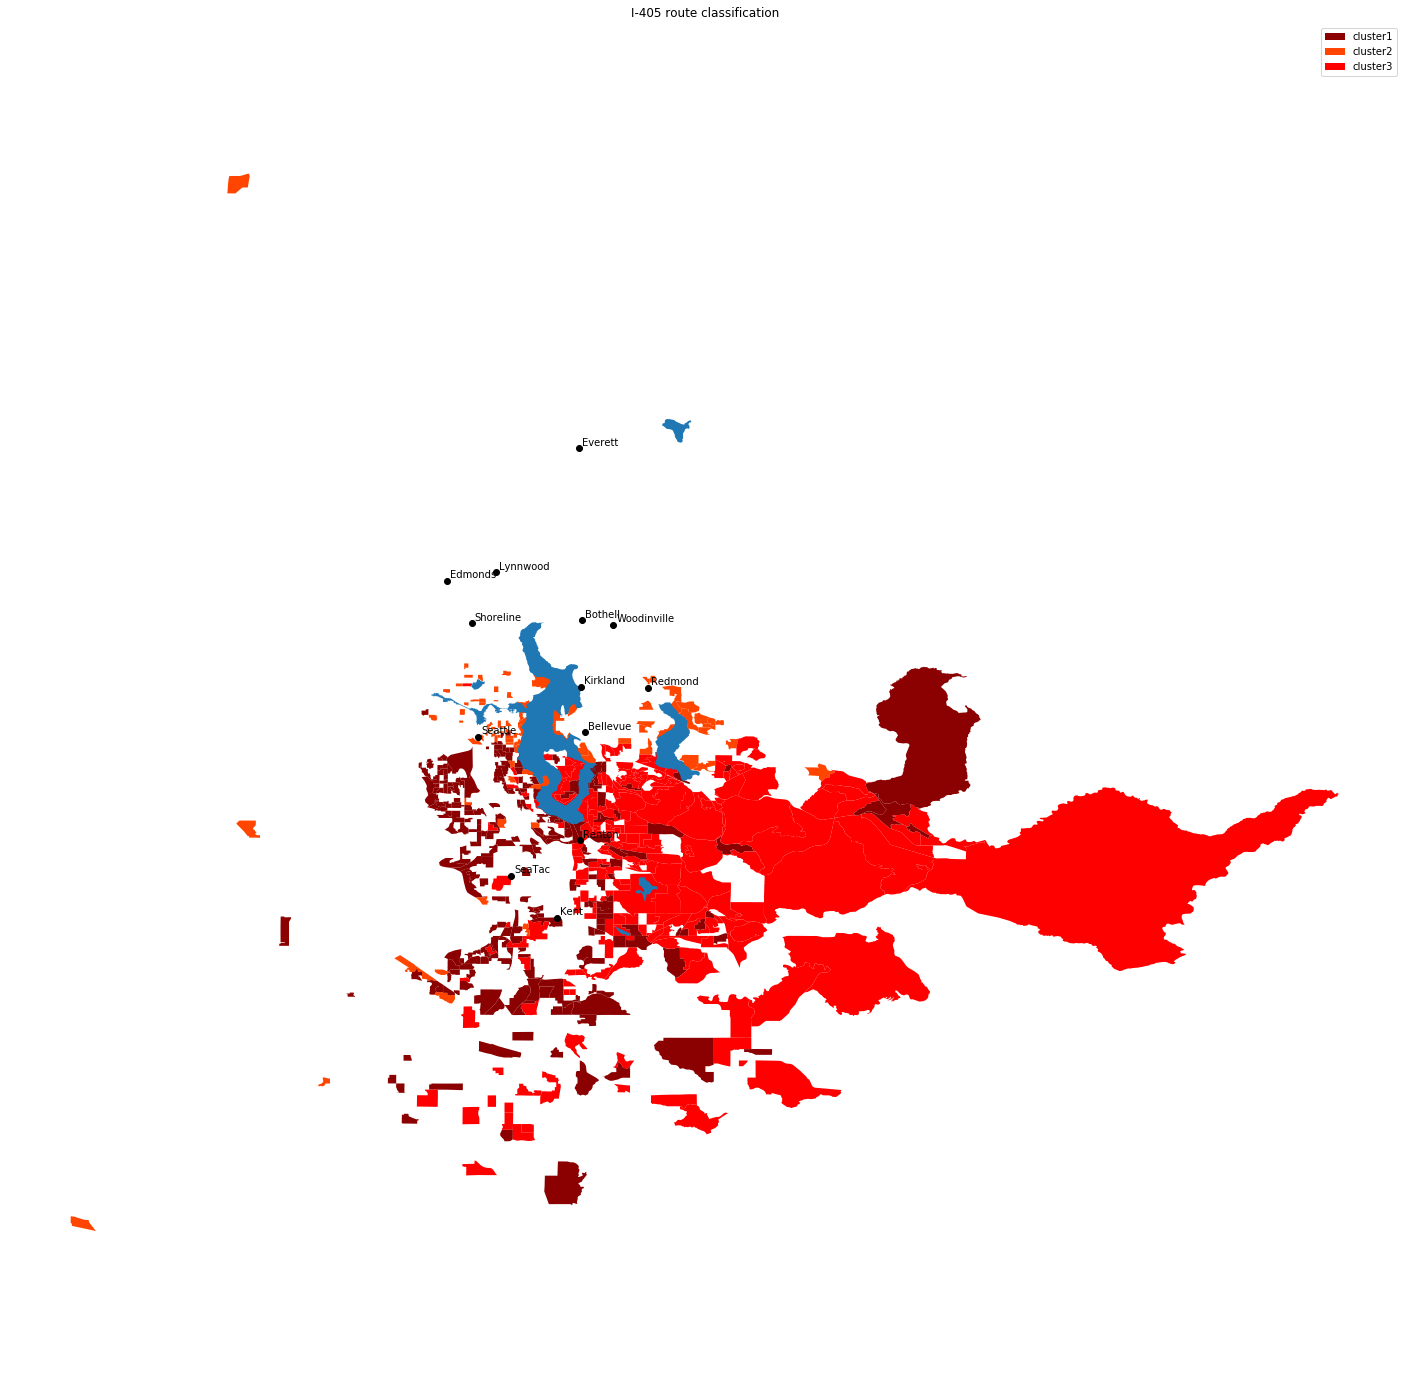

<Figure size 432x288 with 0 Axes>

In [67]:
for i in dfnew['k3cls'].unique():
    print(i)
    dfsub = dfnew[dfnew['k3cls']== i]
    kmeansroute = cluster.KMeans(n_clusters=3)
    kmeansroutec = kmeansroute.fit(dfsub[routes_to_normalize])
    dfsub['route_cluster'] = kmeansroutec.labels_
    kroutesizes = dfsub.groupby('route_cluster').size()
    print(kroutesizes)
    kroutemeans = dfsub.groupby('route_cluster')[routes_to_normalize].mean()
    print(kroutemeans.T)
    kroutedesc = dfsub.groupby('route_cluster')[['trips_per_hh','avg_relibility', 'avg_ttsaving','avg_ttsaving']].describe()
    display(kroutedesc)
    f, ax = plt.subplots(1, figsize=(25, 25))
    keys = list(dfsub['route_cluster'].unique())
    if (i == 1):
        colors = ['sandybrown','darkorange','coral']
    elif (i == 2):
        colors = ['gold','goldenrod','khaki']
    else:
        colors = ['orangered','red','darkred']
    color_dict = dict(zip(keys, colors))
    dfsub.plot(column='route_cluster', categorical=True,color = dfsub['route_cluster'].apply(lambda x:  color_dict[x]), linewidth=0, axes=ax)
    majlks.plot(axes=ax)
    majcps.plot(axes=ax,color='black')
    for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    ax.set_axis_off()
    plt.axis('equal')
    recs = []
    for i in range(0,len(keys)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=color_dict[i]))
    ax.legend(recs,["cluster1","cluster2","cluster3"])
    plt.title('I-405 route classification')
    plt.show()
    name = '../../notebooks/Kiana/figures/peak_'+str(i)+ '_routes'
    plt.savefig(name,dpi = 400)

# Mapping the clusters <br>
From cited notebook and Shirley's notebook

[0, 2, 1]


/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:389: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


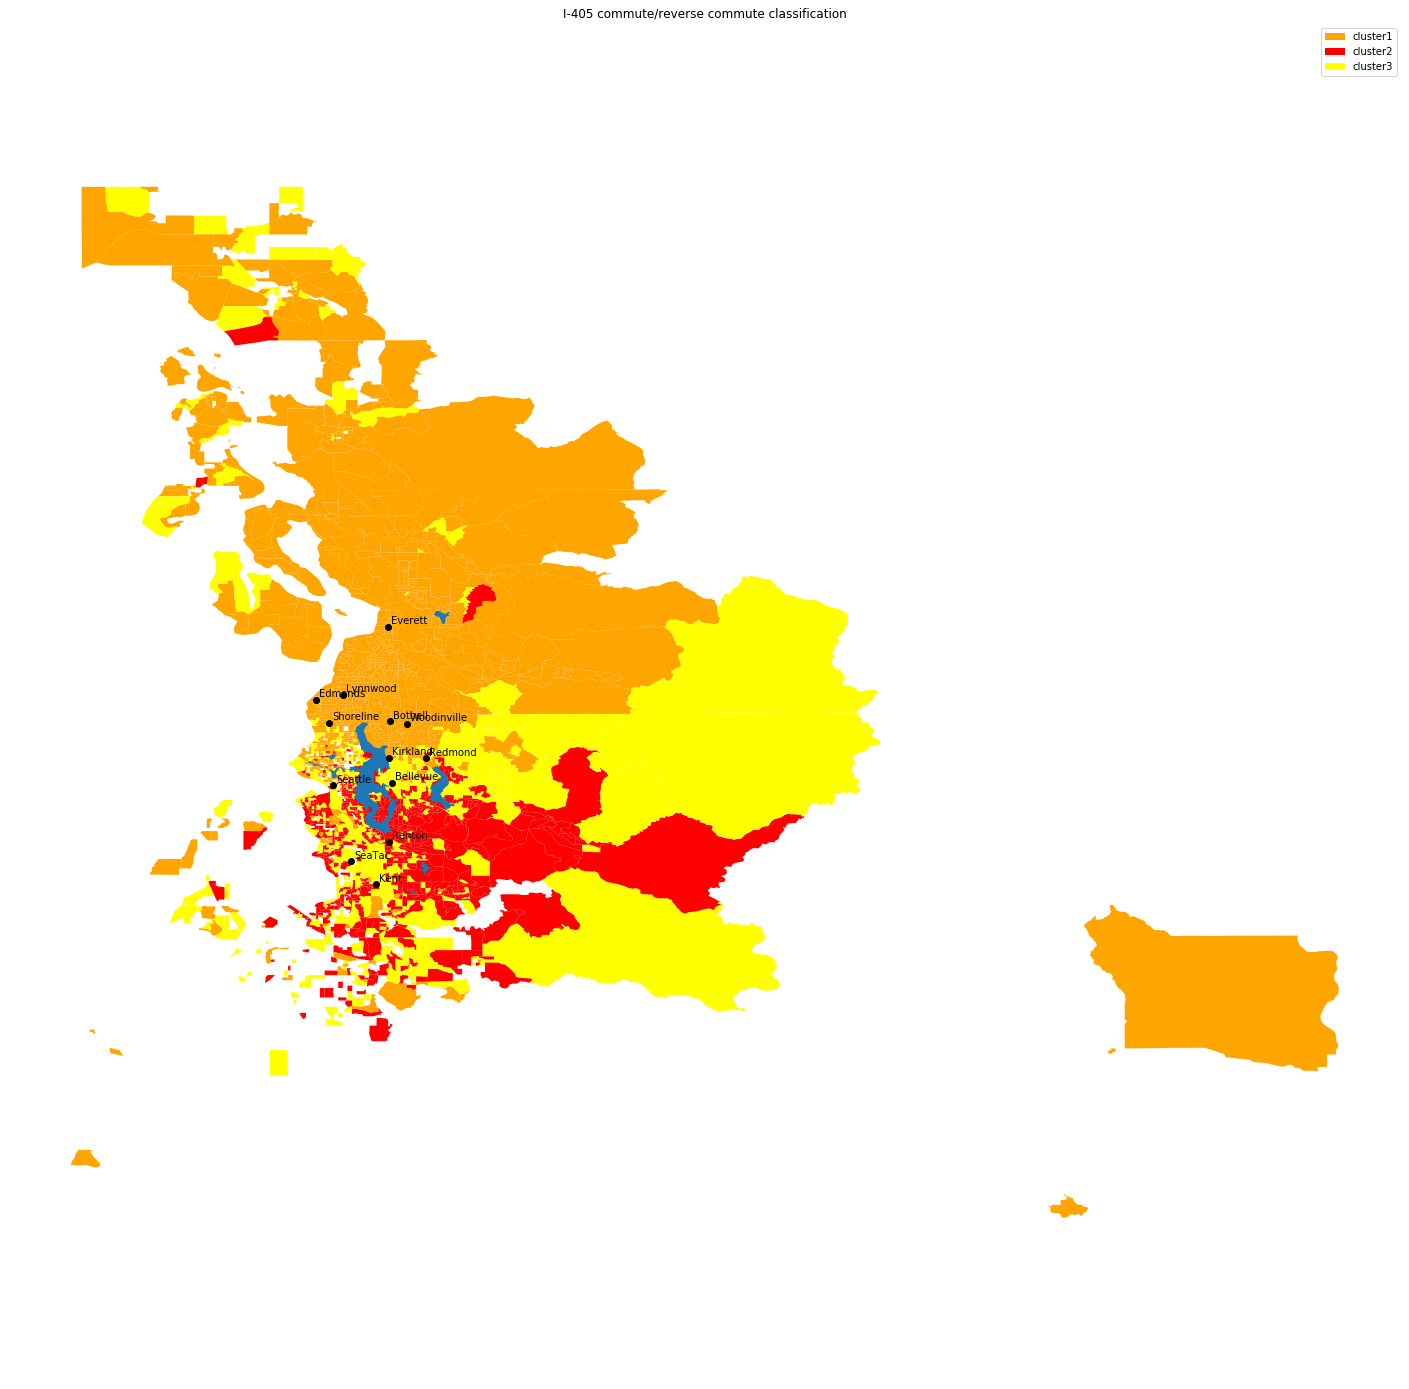

In [69]:

f, ax = plt.subplots(1, figsize=(25, 25))
keys = list(dfnew['k3cls'].unique())
print(keys)
colors = ['orange','yellow','red','green','purple']
color_dict = dict(zip(keys, colors))
dfnew.plot(column='k3cls', categorical=True,color = dfnew['k3cls'].apply(lambda x:  color_dict[x]), linewidth=0, axes=ax)
majlks.plot(axes=ax)
majcps.plot(axes=ax,color='black')
for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
ax.set_axis_off()
plt.axis('equal')
recs = []
for i in range(0,len(keys)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color_dict[i]))
ax.legend(recs,["cluster1","cluster2","cluster3","cluster4","cluster5"])
plt.title('I-405 commute/reverse commute classification')
plt.show()
f.savefig('../../notebooks/Kiana/figures/clustering_commute_3clusters.png',dpi = 400)

Plotting distribution for attributes of the clusters <br>
From cited notebook

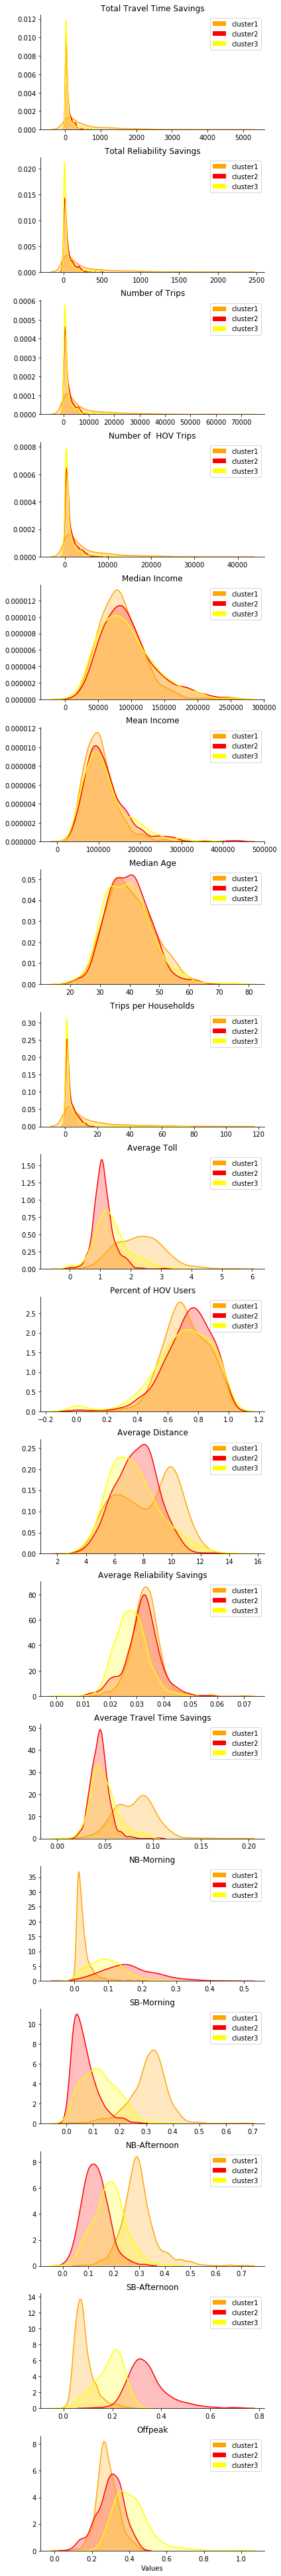

In [70]:
features = ['total_tt_saving','total_reliability_saving','num_trips','num_hov','med_inc','mean_inc','med_age','trips_per_hh','avg_toll','percent_hov','avg_dist', 'avg_relibility','avg_ttsaving'] + peak_to_normalize
to_plot = dfnew.set_index('k3cls')
to_plot = to_plot[features]
to_plot = to_plot.stack()
to_plot = to_plot.reset_index()
to_plot = to_plot.rename(columns={'level_1': 'variables', 0: 'Values'})
facets = sns.FacetGrid(data=to_plot, row='variables', palette = color_dict, hue='k3cls',sharey=False, sharex=False, aspect=2)
_ = facets.map(sns.kdeplot, 'Values', shade=True)
for i in range(0,len(keys)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color_dict[i]))
name = ['Total Travel Time Savings',
        'Total Reliability Savings',
        'Number of Trips','Number of  HOV Trips',
        'Median Income',
        'Mean Income',
        'Median Age',
        'Trips per Households',
        'Average Toll',
        'Percent of HOV Users',
        'Average Distance', 
        'Average Reliability Savings',
        'Average Travel Time Savings',
       'NB-Morning','SB-Morning','NB-Afternoon','SB-Afternoon','Offpeak']
for i in range(0,len(features)):
    facets.axes[i][0].legend(recs,["cluster1","cluster2","cluster3"])
    facets.axes[i,0].set_title(str(name[i]))
f.savefig('../../notebooks/Kiana/figures/clustering_commute_3clusters_features.png',dpi = 400)

Clustering based on routes

In [35]:
from sklearn import cluster
kmeans3 = cluster.KMeans(n_clusters=3)
dfnew  = dfnew[dfnew['trips_per_hh']>= 0.5]          
k3cls = kmeans3.fit(dfnew[routes_to_normalize])
k3cls.labels_
dfnew['k3cls'] = k3cls.labels_
k3sizes = dfnew.groupby('k3cls').size()
print(k3sizes)
k3means = dfnew.groupby('k3cls')[routes_to_normalize].mean()
print(k3means.T)
k3desc = dfnew.groupby('k3cls')[['trips_per_hh','avg_relibility', 'avg_ttsaving','avg_ttsaving']].describe()

k3cls
0    739
1    589
2    752
dtype: int64
k3cls              0         1         2
norm_03_03  0.011482  0.007385  0.049445
norm_03_05  0.028833  0.011539  0.070511
norm_03_06  0.043053  0.021137  0.070602
norm_03_07  0.011892  0.004258  0.025367
norm_03_09  0.011538  0.011901  0.021548
...              ...       ...       ...
norm_21_21  0.001945  0.001162  0.004701
norm_21_22  0.018507  0.009579  0.073776
norm_21_23  0.005038  0.001620  0.007501
norm_22_22  0.009828  0.005311  0.027099
norm_23_23  0.001338  0.000556  0.001843

[99 rows x 3 columns]


/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:389: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


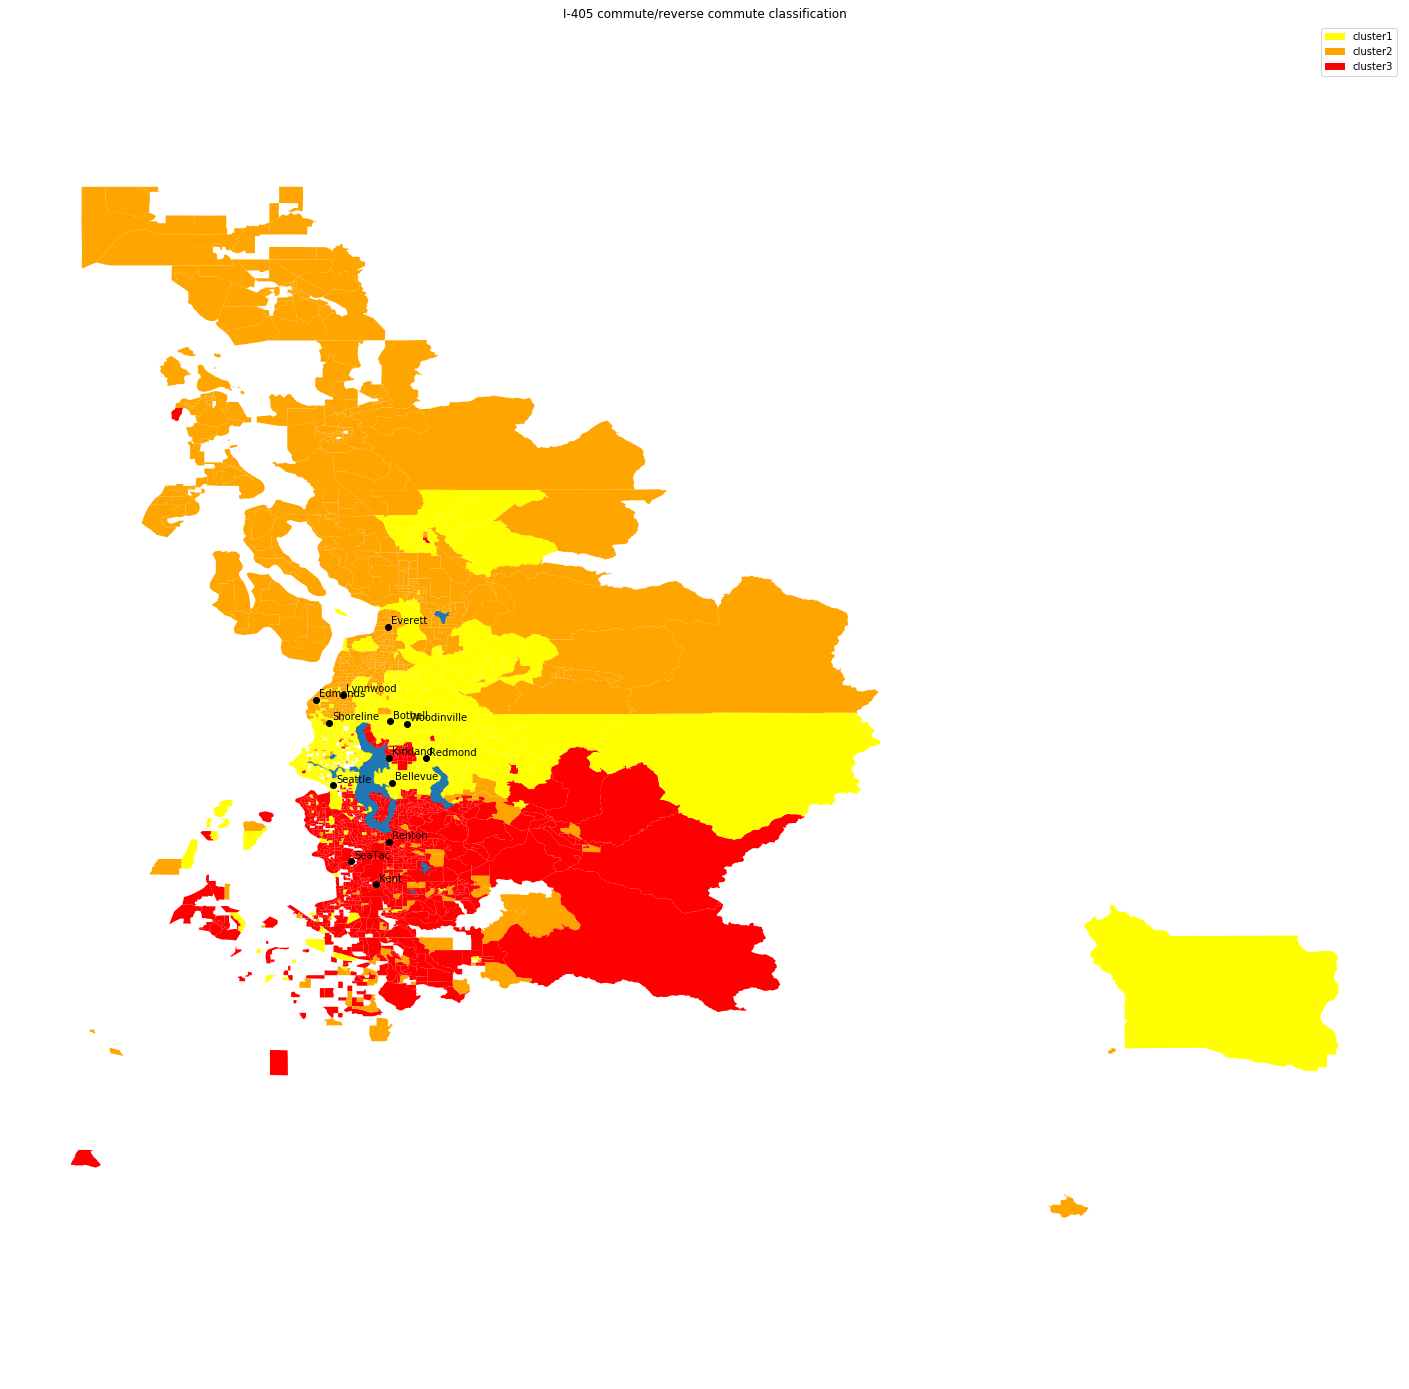

In [36]:
import matplotlib.patches as mpatches
f, ax = plt.subplots(1, figsize=(25, 25))
keys = list(dfnew['k3cls'].unique())
colors = ['orange','yellow','red']
color_dict = dict(zip(keys, colors))
dfnew.plot(column='k3cls', categorical=True,color = dfnew['k3cls'].apply(lambda x:  color_dict[x]), linewidth=0, axes=ax)
majlks.plot(axes=ax)
majcps.plot(axes=ax,color='black')
for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
ax.set_axis_off()
plt.axis('equal')
recs = []
for i in range(0,len(keys)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color_dict[i]))
ax.legend(recs,["cluster1","cluster2","cluster3"])
plt.title('I-405 commute/reverse commute classification')
plt.show()
f.savefig('../../notebooks/Kiana/figures/clustering_routes_3clusters.png',dpi = 400)

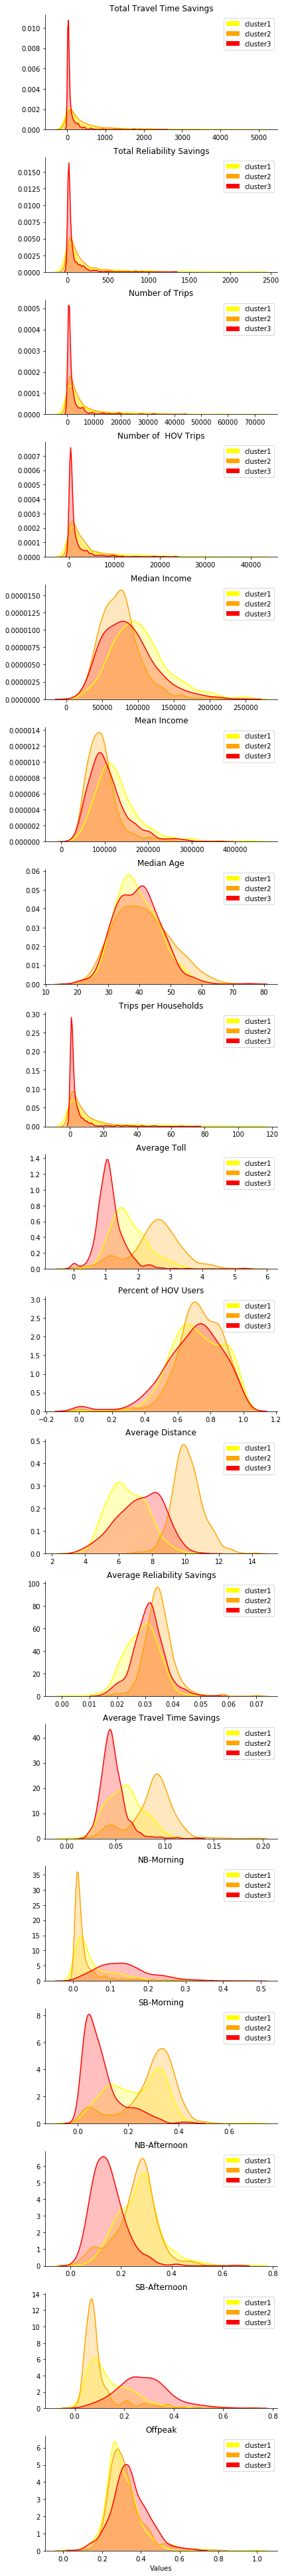

In [37]:
features = ['total_tt_saving','total_reliability_saving','num_trips','num_hov','med_inc','mean_inc','med_age','trips_per_hh','avg_toll','percent_hov','avg_dist', 'avg_relibility','avg_ttsaving'] + peak_to_normalize
to_plot = dfnew.set_index('k3cls')
to_plot = to_plot[features]
to_plot = to_plot.stack()
to_plot = to_plot.reset_index()
to_plot = to_plot.rename(columns={'level_1': 'variables', 0: 'Values'})
facets = sns.FacetGrid(data=to_plot, row='variables', palette = color_dict, hue='k3cls',sharey=False, sharex=False, aspect=2)
_ = facets.map(sns.kdeplot, 'Values', shade=True)
for i in range(0,len(keys)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color_dict[i]))
name = ['Total Travel Time Savings',
        'Total Reliability Savings',
        'Number of Trips','Number of  HOV Trips',
        'Median Income',
        'Mean Income',
        'Median Age',
        'Trips per Households',
        'Average Toll',
        'Percent of HOV Users',
        'Average Distance', 
        'Average Reliability Savings',
        'Average Travel Time Savings',
       'NB-Morning','SB-Morning','NB-Afternoon','SB-Afternoon','Offpeak']
for i in range(0,len(features)):
    facets.axes[i][0].legend(recs,["cluster1","cluster2","cluster3"])
    facets.axes[i,0].set_title(str(name[i]))
plt.savefig('../../notebooks/Kiana/figures/clustering_routes_3clusters_features.png',dpi = 400)

cluster based on avg # of trips and avg tt saving

In [87]:
kmeans3 = cluster.KMeans(n_clusters=3)
dfnew  = dfnew[dfnew['trips_per_hh']>= 0.5]
dfnew.reset_index(drop = True,inplace = True)
min_max_scaler = preprocessing.MinMaxScaler()
trips_per_hh_scaled = min_max_scaler.fit_transform(dfnew['trips_per_hh'].values.astype(float).reshape(-1, 1))
dfnew['trips_per_hh_norm'] = pd.DataFrame(trips_per_hh_scaled)
avg_ttsaving_scaled = min_max_scaler.fit_transform(dfnew['avg_ttsaving'].values.astype(float).reshape(-1, 1))
dfnew['avg_ttsaving_norm'] = pd.DataFrame(avg_ttsaving_scaled)
k3cls = kmeans3.fit(dfnew[['trips_per_hh_norm','avg_ttsaving_norm']])
k3cls.labels_
dfnew['k3cls'] = k3cls.labels_
k3sizes = dfnew.groupby('k3cls').size()
print(k3sizes)
k3means = dfnew.groupby('k3cls')[['trips_per_hh','avg_ttsaving']].mean()
print(k3means.T)
k3desc = dfnew.groupby('k3cls')[['trips_per_hh','avg_relibility', 'avg_ttsaving','avg_ttsaving']].describe()

k3cls
0     686
1    1246
2     148
dtype: int64
k3cls                0         1          2
trips_per_hh  7.782131  3.362049  47.450895
avg_ttsaving  0.091328  0.047001   0.065663


[0, 1, 2]


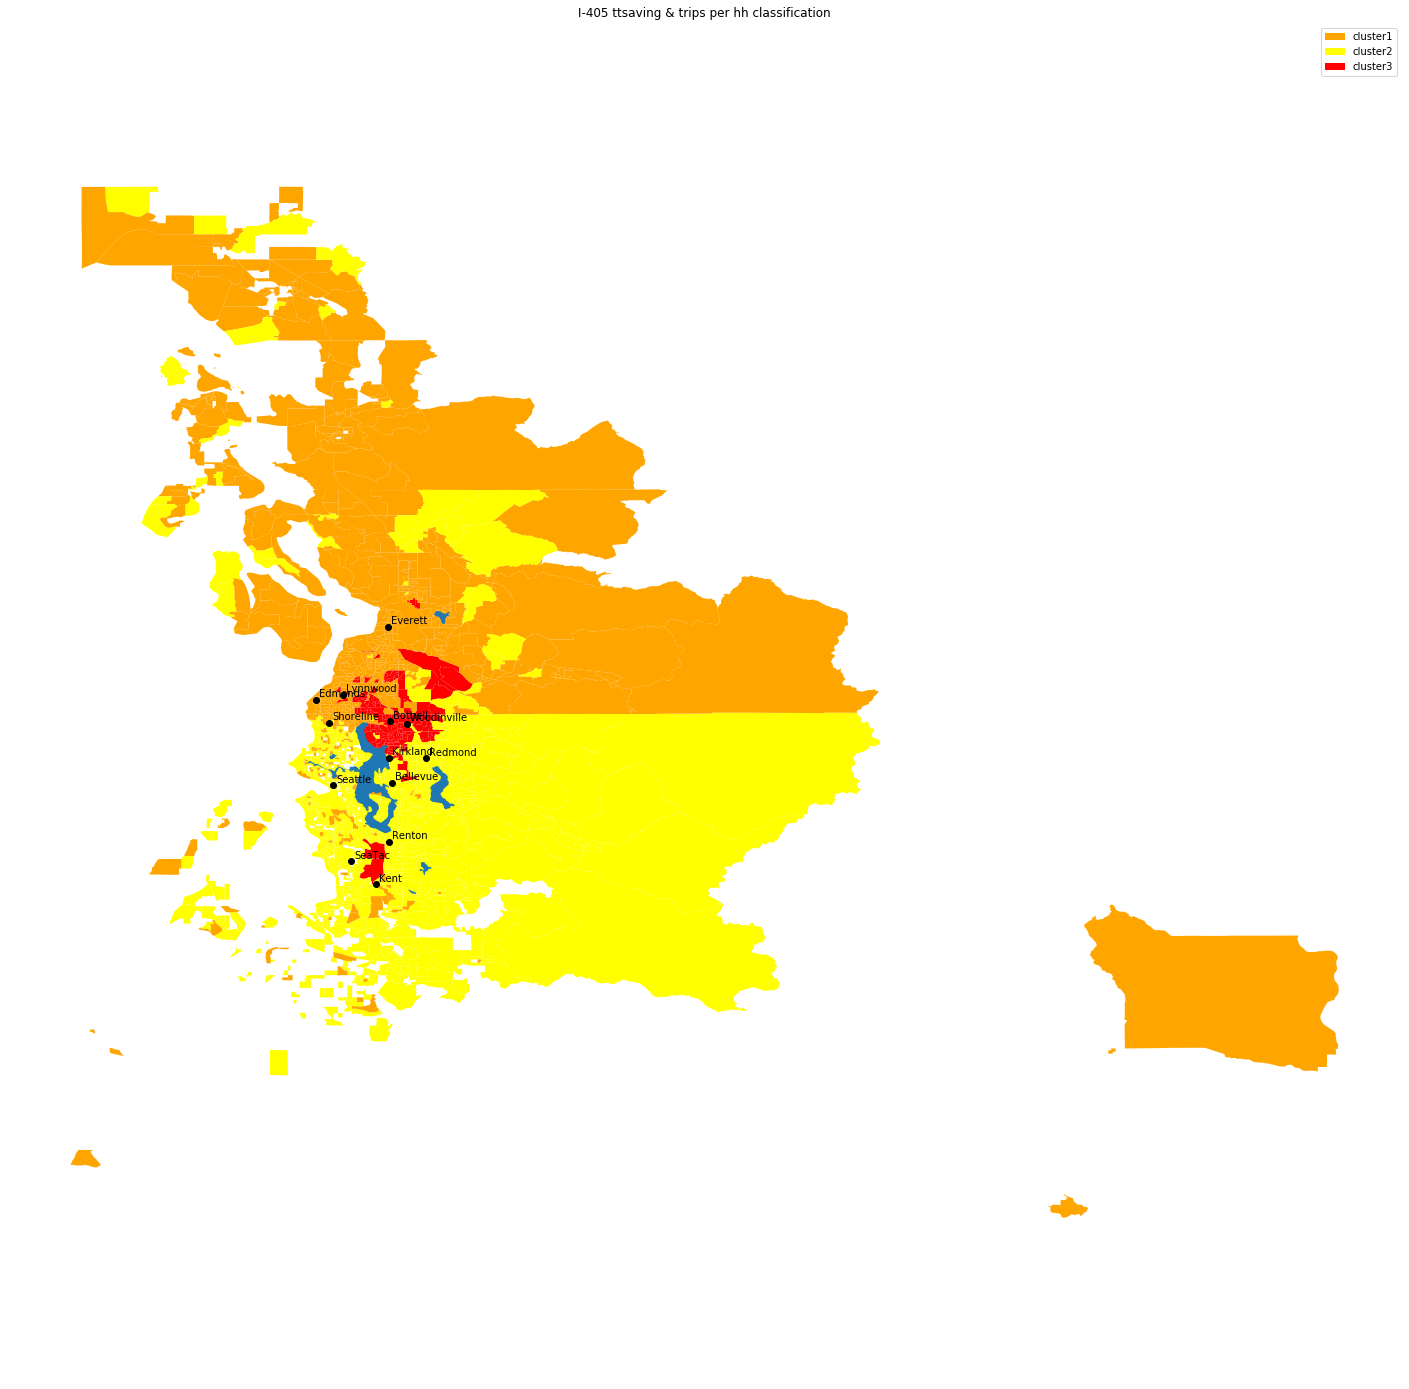

In [90]:
import matplotlib.patches as mpatches
f, ax = plt.subplots(1, figsize=(25, 25))
keys = list(dfnew['k3cls'].unique())
print(keys)
colors = ['orange','yellow','red']
color_dict = dict(zip(keys, colors))
dfnew.plot(column='k3cls', categorical=True,color = dfnew['k3cls'].apply(lambda x:  color_dict[x]), linewidth=0, axes=ax)
majlks.plot(axes=ax)
majcps.plot(axes=ax,color='black')
for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
ax.set_axis_off()
plt.axis('equal')
recs = []
for i in range(0,len(keys)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color_dict[i]))
ax.legend(recs,["cluster1","cluster2","cluster3"])
plt.title('I-405 ttsaving & trips per hh classification')
plt.show()
f.savefig('../../notebooks/Kiana/figures/clustering_trips_per_hh_and_avg_ttsaving.png',dpi = 400)

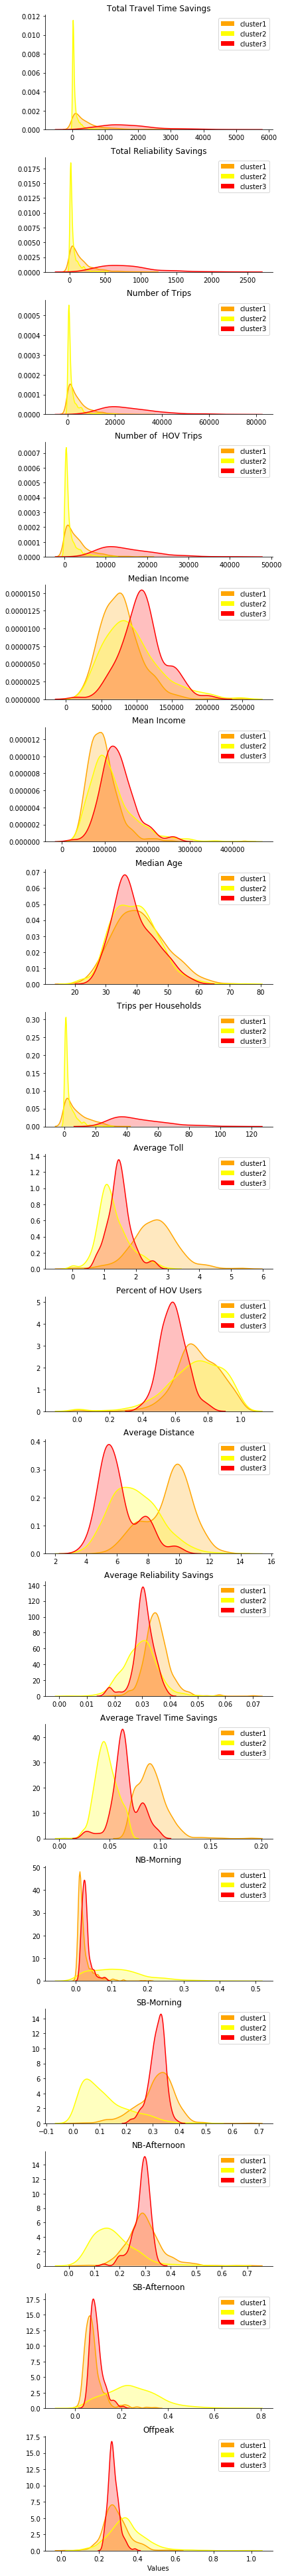

In [91]:
features = ['total_tt_saving','total_reliability_saving','num_trips','num_hov','med_inc','mean_inc','med_age','trips_per_hh','avg_toll','percent_hov','avg_dist', 'avg_relibility','avg_ttsaving'] + peak_to_normalize
to_plot = dfnew.set_index('k3cls')
to_plot = to_plot[features]
to_plot = to_plot.stack()
to_plot = to_plot.reset_index()
to_plot = to_plot.rename(columns={'level_1': 'variables', 0: 'Values'})
facets = sns.FacetGrid(data=to_plot, row='variables', palette = color_dict, hue='k3cls',sharey=False, sharex=False, aspect=2)
_ = facets.map(sns.kdeplot, 'Values', shade=True)
for i in range(0,len(keys)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color_dict[i]))
name = ['Total Travel Time Savings',
        'Total Reliability Savings',
        'Number of Trips','Number of  HOV Trips',
        'Median Income',
        'Mean Income',
        'Median Age',
        'Trips per Households',
        'Average Toll',
        'Percent of HOV Users',
        'Average Distance', 
        'Average Reliability Savings',
        'Average Travel Time Savings',
       'NB-Morning','SB-Morning','NB-Afternoon','SB-Afternoon','Offpeak']
for i in range(0,len(features)):
    facets.axes[i][0].legend(recs,["cluster1","cluster2","cluster3"])
    facets.axes[i,0].set_title(str(name[i]))
plt.savefig('../../notebooks/Kiana/figures/clustering_trips_per_hh_and_avg_ttsaving_features.png',dpi = 400)

In [ ]:
clustering based on income and lat/lon

In [96]:
kmeans3 = cluster.KMeans(n_clusters=5)
dfnew  = dfnew[dfnew['trips_per_hh']>= 0.5]
dfnew.reset_index(drop = True,inplace = True)
min_max_scaler = preprocessing.MinMaxScaler()
mean_inc_scaled = min_max_scaler.fit_transform(dfnew['mean_inc'].values.astype(float).reshape(-1, 1))
dfnew['mean_inc_norm'] = pd.DataFrame(mean_inc_scaled)
lat_scaled = min_max_scaler.fit_transform(dfnew['lat'].values.astype(float).reshape(-1, 1))
dfnew['lat_norm'] = pd.DataFrame(lat_scaled)
lon_scaled = min_max_scaler.fit_transform(dfnew['lon'].values.astype(float).reshape(-1, 1))
dfnew['lon_norm'] = pd.DataFrame(lon_scaled)
dfnew['net_benefit']
k3cls = kmeans3.fit(dfnew[['mean_inc_norm','lat_norm','lon_norm']])
k3cls.labels_
dfnew['k3cls'] = k3cls.labels_
k3sizes = dfnew.groupby('k3cls').size()
print(k3sizes)
k3means = dfnew.groupby('k3cls')[['mean_inc_norm','lat_norm','lon_norm']].mean()
print(k3means.T)
k3desc = dfnew.groupby('k3cls')[['trips_per_hh','avg_relibility', 'avg_ttsaving','avg_ttsaving']].describe()

k3cls
0    644
1    142
2    579
3    566
4    149
dtype: int64
k3cls                 0         1         2         3         4
mean_inc_norm  0.151807  0.144182  0.280781  0.154521  0.509465
lat_norm       0.321118  0.803387  0.430582  0.531380  0.420858
lon_norm       0.250678  0.173733  0.261902  0.264411  0.277894


[0, 1, 2, 3, 4]


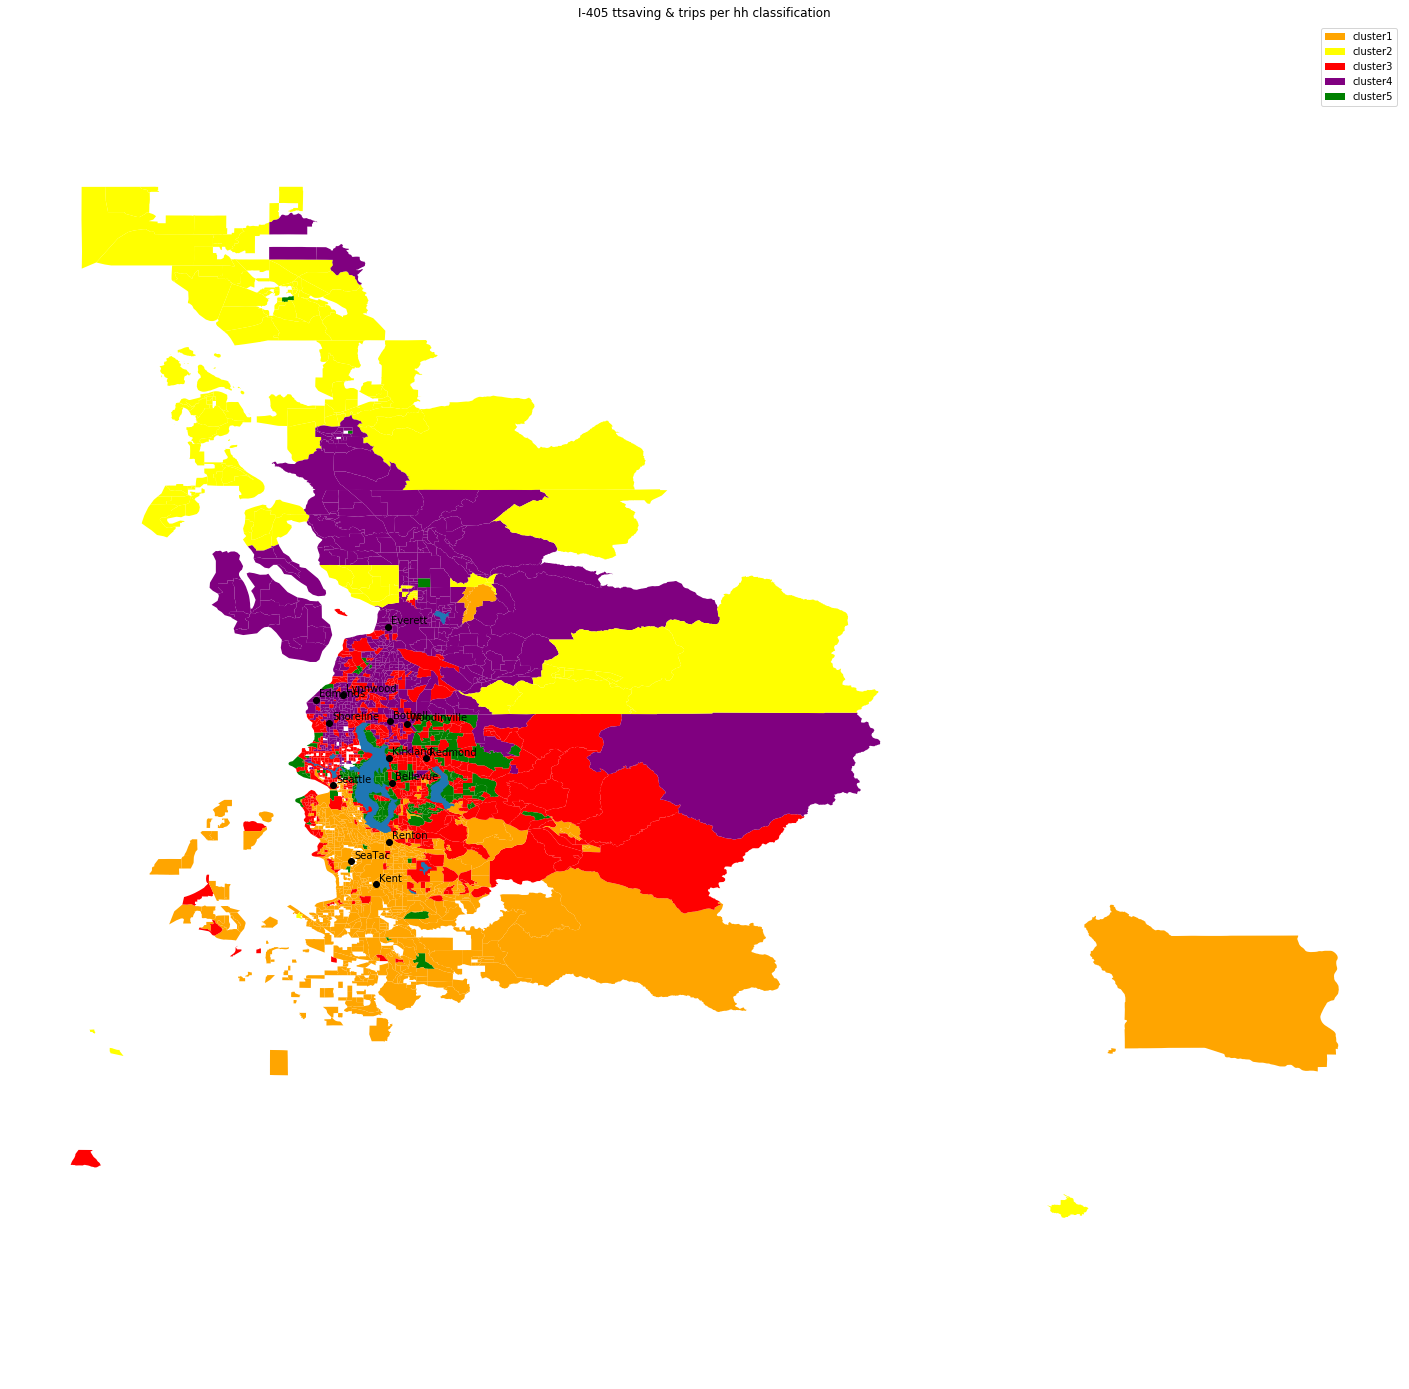

In [108]:
import matplotlib.patches as mpatches
f, ax = plt.subplots(1, figsize=(25, 25))
keys = list(dfnew['k3cls'].unique())
keys.sort()
print(keys)
colors = ['orange','yellow','red','purple','green']
color_dict = dict(zip(keys, colors))
dfnew.plot(column='k3cls', categorical=True,color = dfnew['k3cls'].apply(lambda x:  color_dict[x]), linewidth=0, axes=ax)
majlks.plot(axes=ax)
majcps.plot(axes=ax,color='black')
for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
ax.set_axis_off()
plt.axis('equal')
recs = []
for i in range(0,len(keys)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color_dict[i]))
ax.legend(recs,["cluster1","cluster2","cluster3","cluster4","cluster5"])
plt.title('I-405 ttsaving & trips per hh classification')
plt.show()
f.savefig('../../notebooks/Kiana/figures/clustering_income_location.png',dpi = 400)

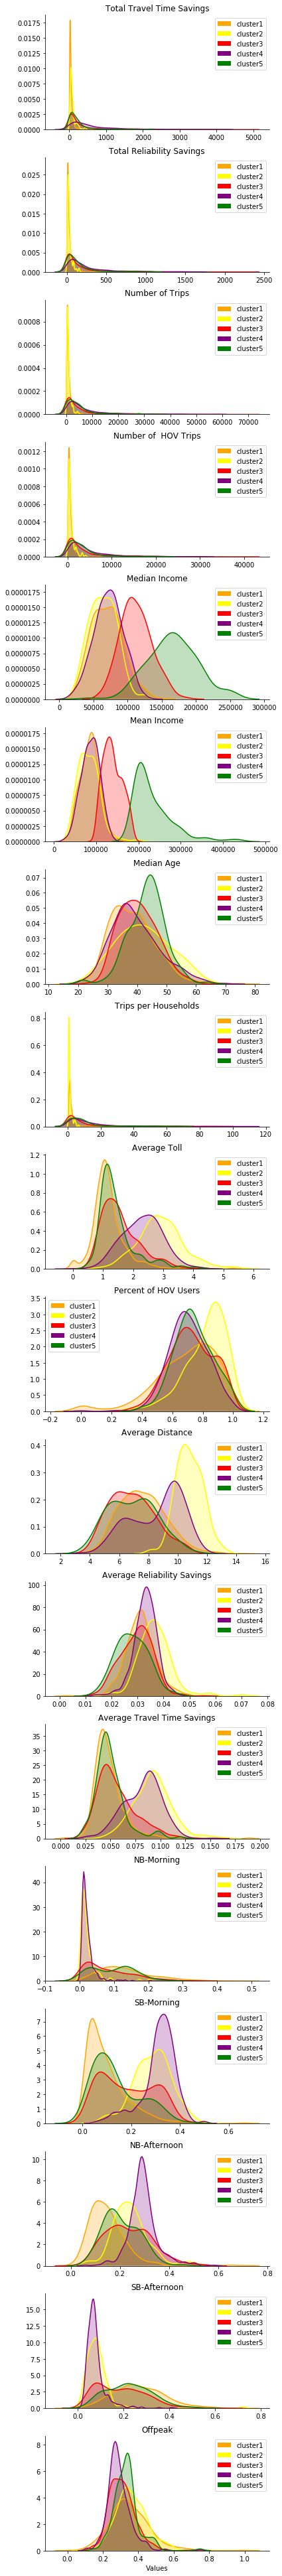

In [109]:
features = ['total_tt_saving','total_reliability_saving','num_trips','num_hov','med_inc','mean_inc','med_age','trips_per_hh','avg_toll','percent_hov','avg_dist', 'avg_relibility','avg_ttsaving'] + peak_to_normalize
to_plot = dfnew.set_index('k3cls')
to_plot = to_plot[features]
to_plot = to_plot.stack()
to_plot = to_plot.reset_index()
to_plot = to_plot.rename(columns={'level_1': 'variables', 0: 'Values'})
facets = sns.FacetGrid(data=to_plot, row='variables', palette = color_dict, hue='k3cls',sharey=False, sharex=False, aspect=2)
_ = facets.map(sns.kdeplot, 'Values', shade=True)
for i in range(0,len(keys)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color_dict[i]))
name = ['Total Travel Time Savings',
        'Total Reliability Savings',
        'Number of Trips','Number of  HOV Trips',
        'Median Income',
        'Mean Income',
        'Median Age',
        'Trips per Households',
        'Average Toll',
        'Percent of HOV Users',
        'Average Distance', 
        'Average Reliability Savings',
        'Average Travel Time Savings',
       'NB-Morning','SB-Morning','NB-Afternoon','SB-Afternoon','Offpeak']
for i in range(0,len(features)):
    facets.axes[i][0].legend(recs,["cluster1","cluster2","cluster3","cluster4","cluster5"])
    facets.axes[i,0].set_title(str(name[i]))
plt.savefig('../../notebooks/Kiana/figures/clustering_income_location_features.png',dpi = 400)

In [121]:
import pysal as ps
import libpysal
from libpysal.weights import Queen, Rook, KNN
import pysal.contrib.clusterpy as cp

ModuleNotFoundError: No module named 'pysal.contrib'

In [110]:
#test = ps.open('../../data/shapefiles//block_groups_WA/bg10.shp')
w = Queen.from_shapefile('../../data/shapefiles/block_groups_WA/bg10.shp','GEOID10')

In [ ]:
layer = cp.Layer()
cp.addArray2Layer(abb[ratings].values, layer, names=ratings)